In [12]:
from os import listdir
from os.path import isfile, join
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import kneighbors_graph
from skimage.transform import rescale, resize
from scipy.ndimage.filters import gaussian_filter
from scipy.io import loadmat
import imageio
from skimage import img_as_uint
import numpy as np
import math
import warnings

In [13]:
## Read images, check all jpg images in path and read them.
## Return a list of images each with a matrix of height * width * 3(channels for colors).
def read_images(path):
    onlyfiles = [f[:-4] for f in listdir(path) if isfile(join(path, f)) and f.endswith('jpg')];
    onlyfiles.sort(key=int);
    data = [];
    for file in onlyfiles:
        file = file + '.jpg';
        total_path = join(path,file);
        img = mpimg.imread(total_path);
        data.append(img);
    return onlyfiles, data;
def read_cluster_images(path):
    onlyfiles = [f[:-4] for f in listdir(path) if isfile(join(path, f)) and f.endswith('png')];
    onlyfiles.sort(key=int);
    data = [];
    for file in onlyfiles:
        file = file + '.png';
        total_path = join(path,file);
        img = imageio.imread(total_path);
        data.append(img);
    return data;
def write_cluster_images(directory, imgs, names, k_param):
    i = 0;
    for k in k_param:
        sub_dir = join(directory, str(k));
        if not os.path.exists(sub_dir):
            os.makedirs(sub_dir);
        j = 0;
        for img in imgs[i]:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                rimg = img_as_uint(img);
                imageio.imwrite(join(sub_dir, names[j] + '.png'), rimg);
            j += 1;
        i += 1;
## Read ground truth from mat files.
## Only care about segmented images, throw away boundary images.
## Return a list of a list of ground truth images.
def read_ground_truth(path):
    onlyfiles = [f[:-4] for f in listdir(path) if isfile(join(path, f)) and f.endswith('mat')];
    onlyfiles.sort(key=int);
    data = [];
    for file in onlyfiles:
        file = file + '.mat';
        total_path = join(path,file);
        img = loadmat(total_path);
        process_img = [];
        for k in np.squeeze(img['groundTruth']).reshape(-1):
            process_img.append(k[0][0][0]);
            ## If we want boundary images with us.
            #for c in k[0][0]:
                #process_img.append(c);
        data.append(process_img);
    return data;
## Show image with its ground truths.
def show_img(real_data, gt_data, names, index):
    kn = 1 + len(gt_data[index]);
    n = int(math.sqrt(kn));
    mn = n;
    if (mn * n < kn):
        mn = mn + 1;
        if (mn * n < kn):
            n = n + 1;
    fig, ax = plt.subplots(n, mn, figsize=(20,20));
    fig.suptitle('Image ' + names[index], fontsize=20)
    ax[0][0].imshow(real_data[index]);
    for i in range(len(gt_data[index])):
        rem = (i + 1) % mn;
        k = int((i + 1) / mn);
        ax[k, rem].imshow(gt_data[index][i]);
    plt.show();
def show_single_img(img):
    plt.imshow(img);
    plt.show();
def show_cluster_img(real_data, kimgs, names, index, k_params):
    kn = 1 + len(kimgs);
    n = int(math.sqrt(kn));
    mn = n;
    if (mn * n < kn):
        mn = mn + 1;
        if (mn * n < kn):
            n = n + 1;
    fig, ax = plt.subplots(n, mn, figsize=(20,20));
    fig.suptitle('Image ' + names[index], fontsize=20)
    ax[0][0].imshow(real_data[index]);
    for i in range(len(kimgs)):
        rem = (i + 1) % mn;
        k = int((i + 1) / mn);
        ax[k, rem].set_title('K = ' + str(k_params[i]));
        ax[k, rem].imshow(kimgs[i][index]);
    plt.show();
def resize_real_img(real_data, reduce_to, apply_gauss = False, sigma = 2):
    resize_data = [];
    for img in real_data:
        gres_img = img.copy();
        res_img = np.zeros( (int(img.shape[0] * reduce_to), int(img.shape[1] * reduce_to), 3));
        if (apply_gauss):
            gres_img[:,:,0] = gaussian_filter(img[:,:,0], sigma=sigma);
            gres_img[:,:,1] = gaussian_filter(img[:,:,1], sigma=sigma);
            gres_img[:,:,2] = gaussian_filter(img[:,:,2], sigma=sigma);
        res_img[:,:,0] = resize(gres_img[:,:,0], (int(img.shape[0] * reduce_to), int(img.shape[1] * reduce_to)),  mode='constant');
        res_img[:,:,1] = resize(gres_img[:,:,1], (int(img.shape[0] * reduce_to), int(img.shape[1] * reduce_to)),  mode='constant');
        res_img[:,:,2] = resize(gres_img[:,:,2], (int(img.shape[0] * reduce_to), int(img.shape[1] * reduce_to)),  mode='constant');
        resize_data.append(res_img);
    return resize_data;
def resize_gt_img(ground_truth, reduce_to, apply_gauss = False, sigma = 2):
    resize_data = [];
    for gt in ground_truth:
        res_data_min = [];
        for img in gt:
            gimg = img;
            if (apply_gauss):
                gimg = gaussian_filter(img, sigma=sigma)
            res_img = resize(gimg, (int(img.shape[0] * reduce_to), int(img.shape[1] * reduce_to)),  mode='constant');
            res_data_min.append(res_img);
        resize_data.append(res_data_min);
    return resize_data;

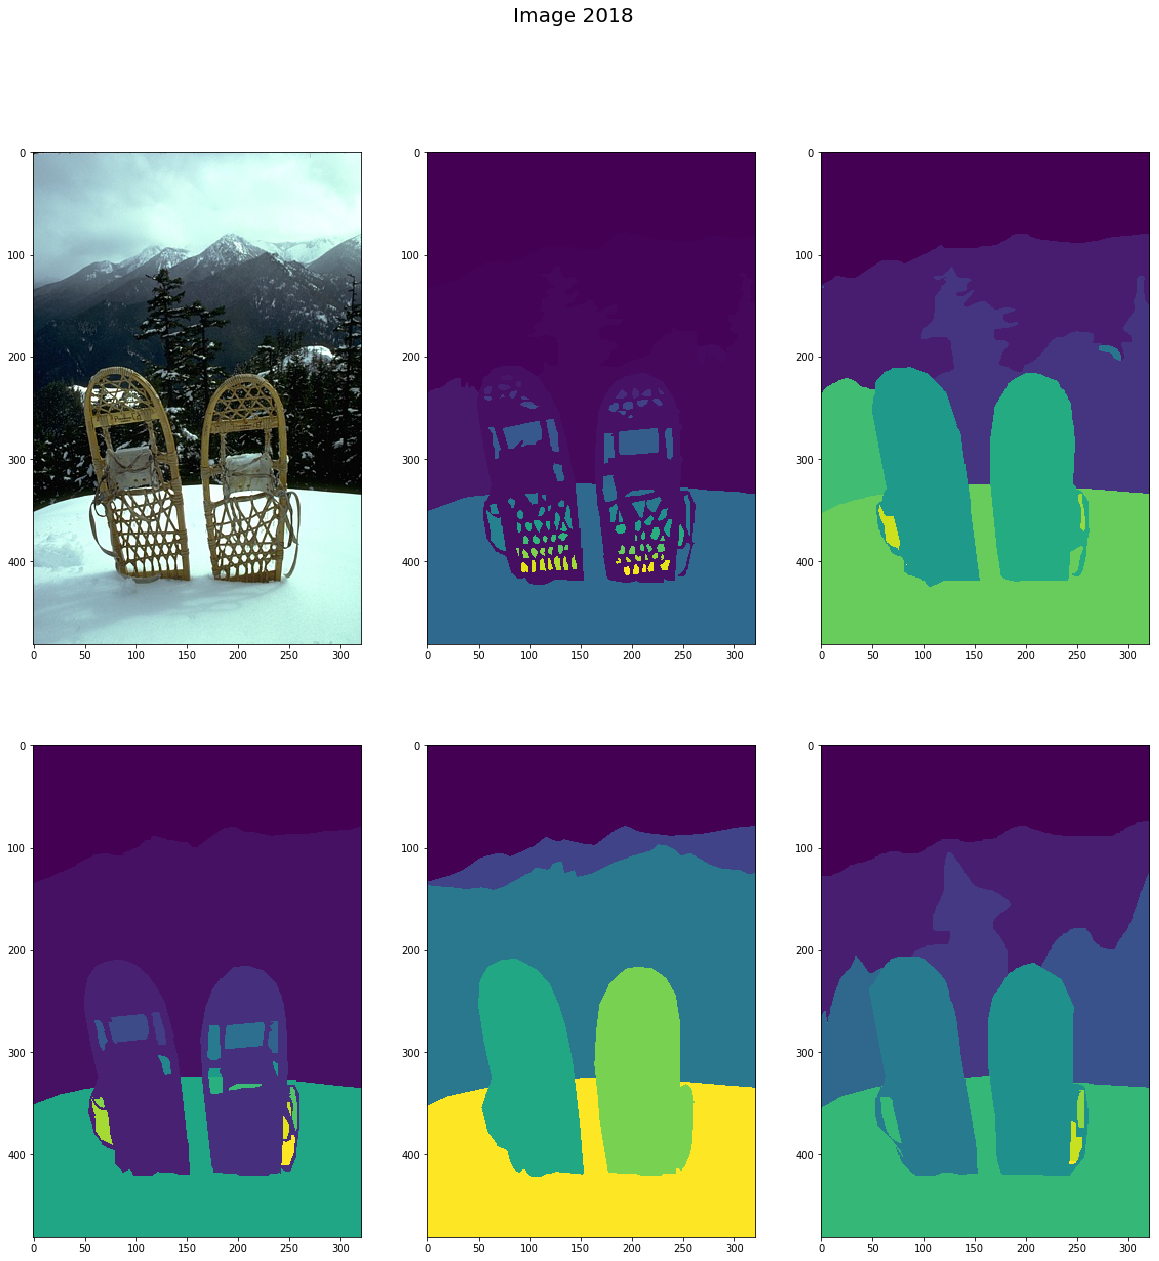

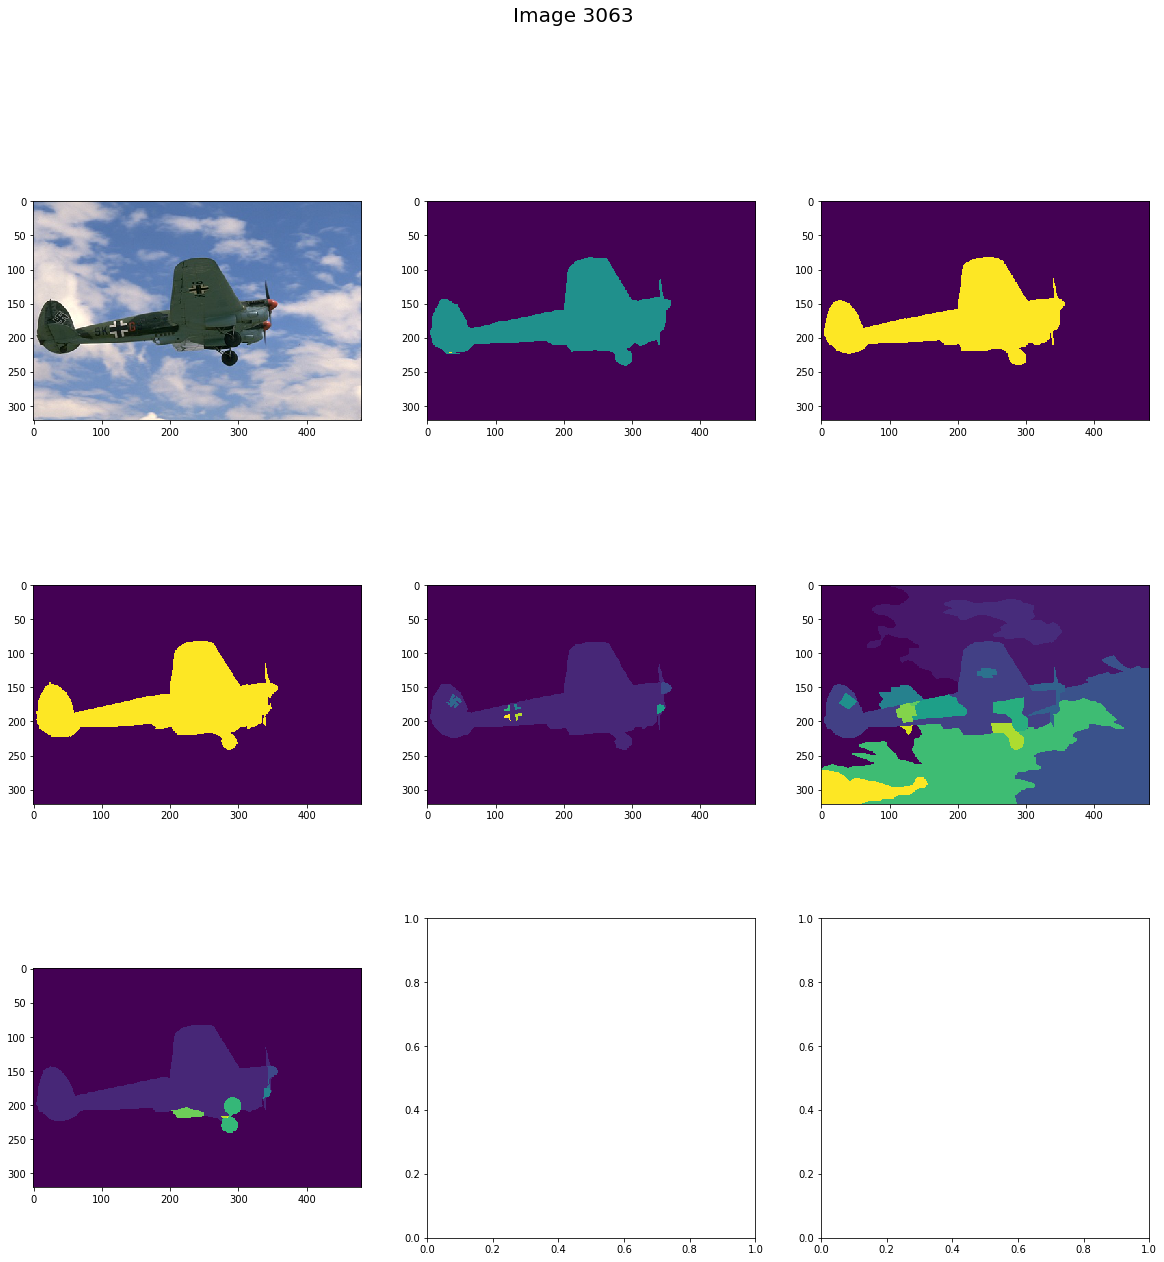

In [4]:
names, real_data = read_images('data/images/test');
real_gt = read_ground_truth('data/groundTruth/test');
show_img(real_data, real_gt, names, 0);
show_img(real_data, real_gt, names, 1);

In [15]:
## K-Means with different k
do_kmeans_run = True;
if do_kmeans_run:
    k_param = [3,5,7,9,11];
    k_results = [];
    for k in k_param:
        min_k = [];
        i = 0;
        print('Starting with k : ', k);
        for img in real_data:
            img_u = img.reshape(-1, 3);
            kmeans = KMeans(n_clusters=k, random_state=0).fit(img_u);
            min_k.append(kmeans.labels_.reshape(img.shape[:-1]));
            i = i + 1;
            if (i % 20 == 0):
                print('Finished : ', i / 2, '%')
        k_results.append(min_k);
else:
    print('Generation bypassed, will be read from stored results...');

Generation bypassed, will be read from stored results...


In [16]:
if do_kmeans_run:
    directory = 'results/kmeans'
    k_param = [3,5,7,9,11];
    write_cluster_images(directory, k_results, names, k_param);
    print('All results saved...');
else:
    print('No results to save, skip to reading');

No results to save, skip to reading


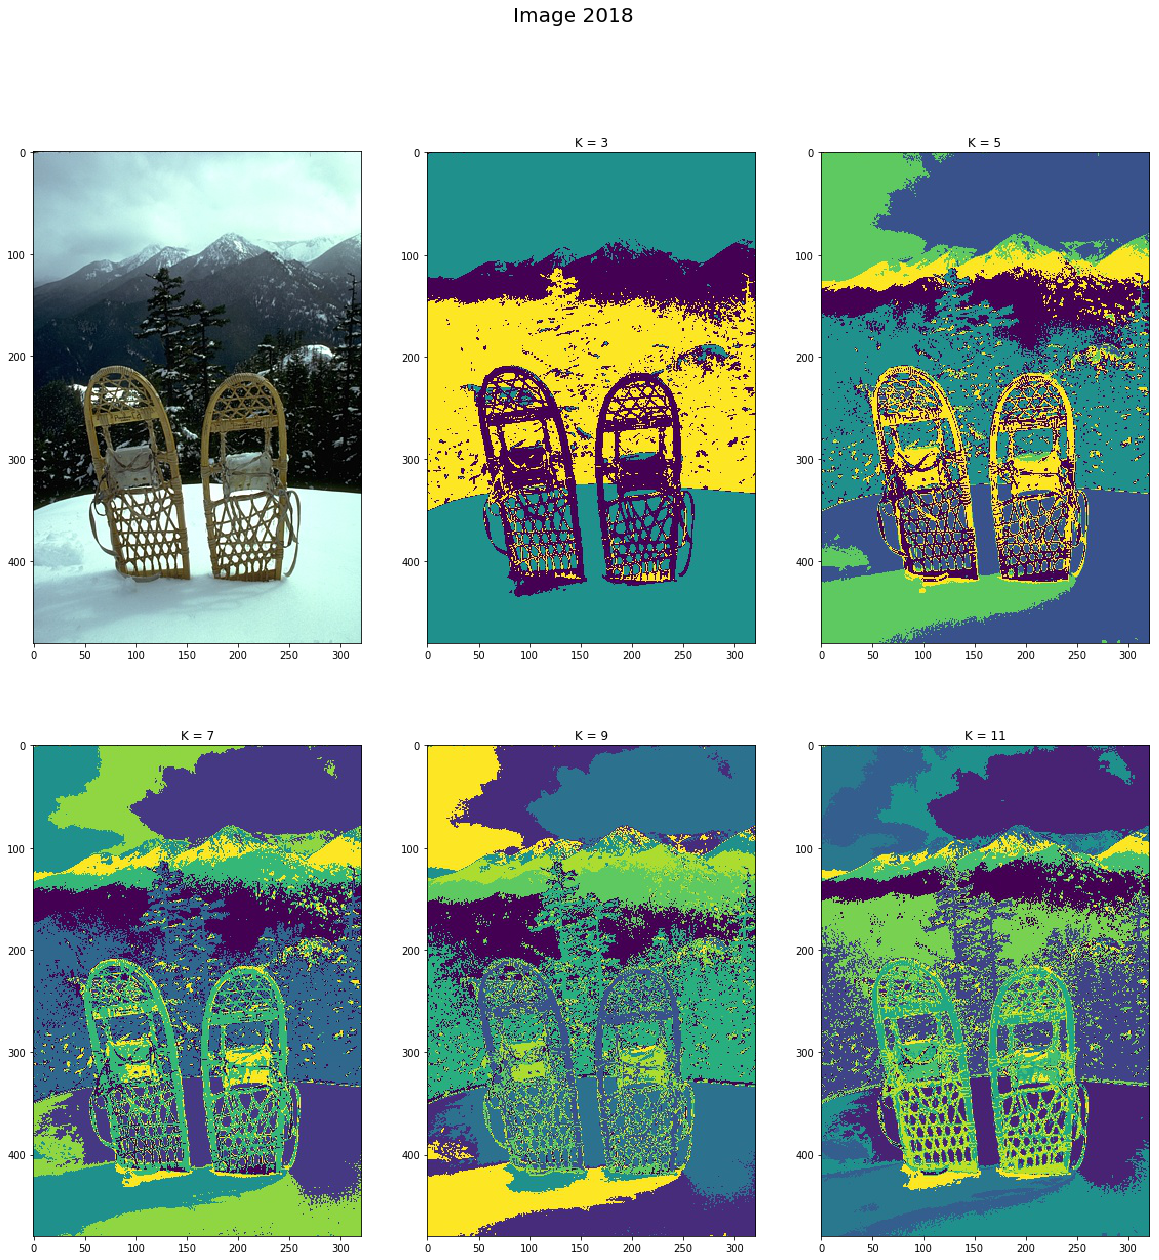

Image 2018
k = 3:
462240
m = 0:
154401


ValueError: row, column, and data array must all be the same length

In [23]:
directory = 'results/kmeans'
k_param = [3,5,7,9,11];
k_results = [];
for k in k_param:
    sub_dir = join(directory, str(k));
    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir);
    lk = read_cluster_images(sub_dir);
    k_results.append(lk);
show_cluster_img(real_data, k_results, names, 0, k_param);
calculate_measures_k(real_gt, k_results, names, 0, k_param);

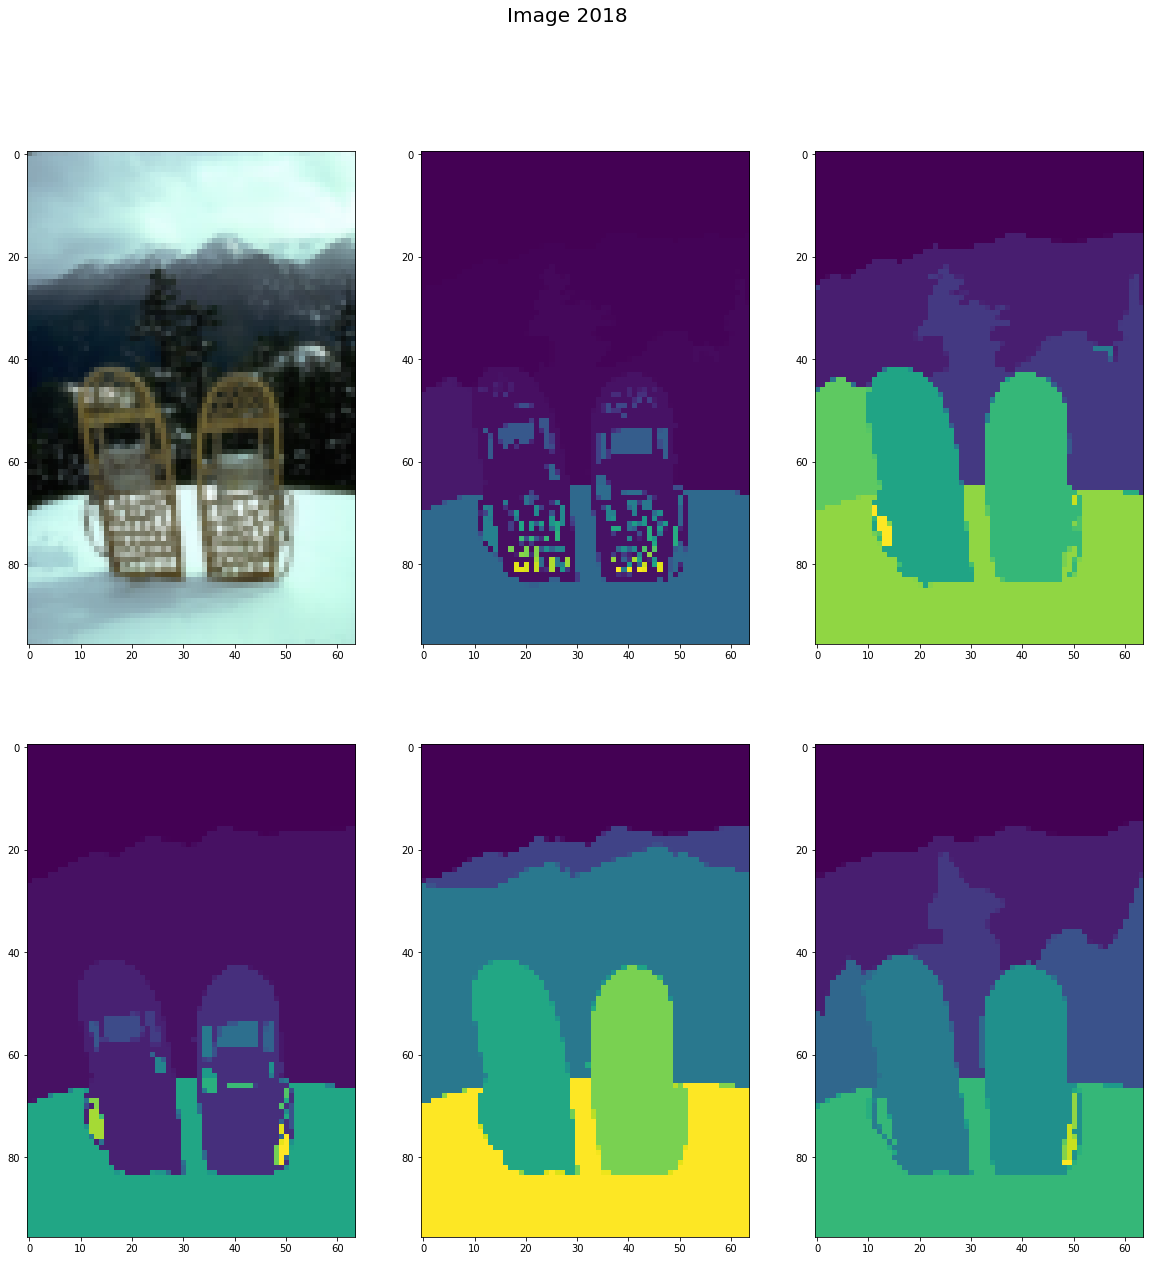

In [89]:
resize_to = 0.2;
mod_data = resize_real_img(real_data, resize_to, True);
mod_gt = resize_gt_img(real_gt, resize_to);
show_img(mod_data, mod_gt, names, 0);

In [78]:
## Spectral clustering with different k
do_spectral_clustering = True;
k_param = [3,5,7,9,11];
s_results = [[[] for i in range(len(k_param))] for j in range(3)];
if do_spectral_clustering:
    index = 0;
    for img in mod_data:
        i = 0;
        img_u = img.reshape(-1, 3);
        ## Following https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
        ## RBF kernel -> np.exp(-gamma * d(X,X) ** 2) where d(X,X) is ecludiean distance.
        spectCluster = SpectralClustering(n_clusters=11, random_state=0, affinity='rbf', gamma = 1);
        rbf_1_aff = spectCluster.fit(img_u).affinity_matrix_;
        spectCluster = SpectralClustering(n_clusters=11, random_state=0, affinity='rbf', gamma = 10);
        rbf_10_aff = spectCluster.fit(img_u).affinity_matrix_;
        spectCluster = SpectralClustering(n_clusters=11, random_state=0, affinity='nearest_neighbors', n_neighbors = 5);
        nn_5_aff = spectCluster.fit(img_u).affinity_matrix_;
        for k in k_param:
            spectCluster = SpectralClustering(n_clusters=k, random_state=0, affinity='precomputed');
            clustering = spectCluster.fit(rbf_1_aff);
            s_results[0][i].append(clustering.labels_.reshape(img.shape[:-1]).copy());
            clustering = spectCluster.fit(rbf_10_aff);
            s_results[1][i].append(clustering.labels_.reshape(img.shape[:-1]).copy());
            clustering = spectCluster.fit(nn_5_aff);
            s_results[2][i].append(clustering.labels_.reshape(img.shape[:-1]).copy());
            i = i + 1;
        index += 1;
        if (index % 20 == 0):
            print('Finished : ', index / 2, '%');
else:
    print('Generation bypassed, will be read from stored results...');

In [82]:
if do_spectral_clustering:
    k_param = [3,5,7,9,11];
    directory = 'results/spectral/rbf_1';
    write_cluster_images(directory, s_results[0], names, k_param);
    directory = 'results/spectral/rbf_10'
    write_cluster_images(directory, s_results[1], names, k_param);
    directory = 'results/spectral/nn_5'
    write_cluster_images(directory, s_results[2], names, k_param);
    print('All results saved...');
else:
    print('No results to save, skip to reading');

All results saved...


RBF with gamma = 1


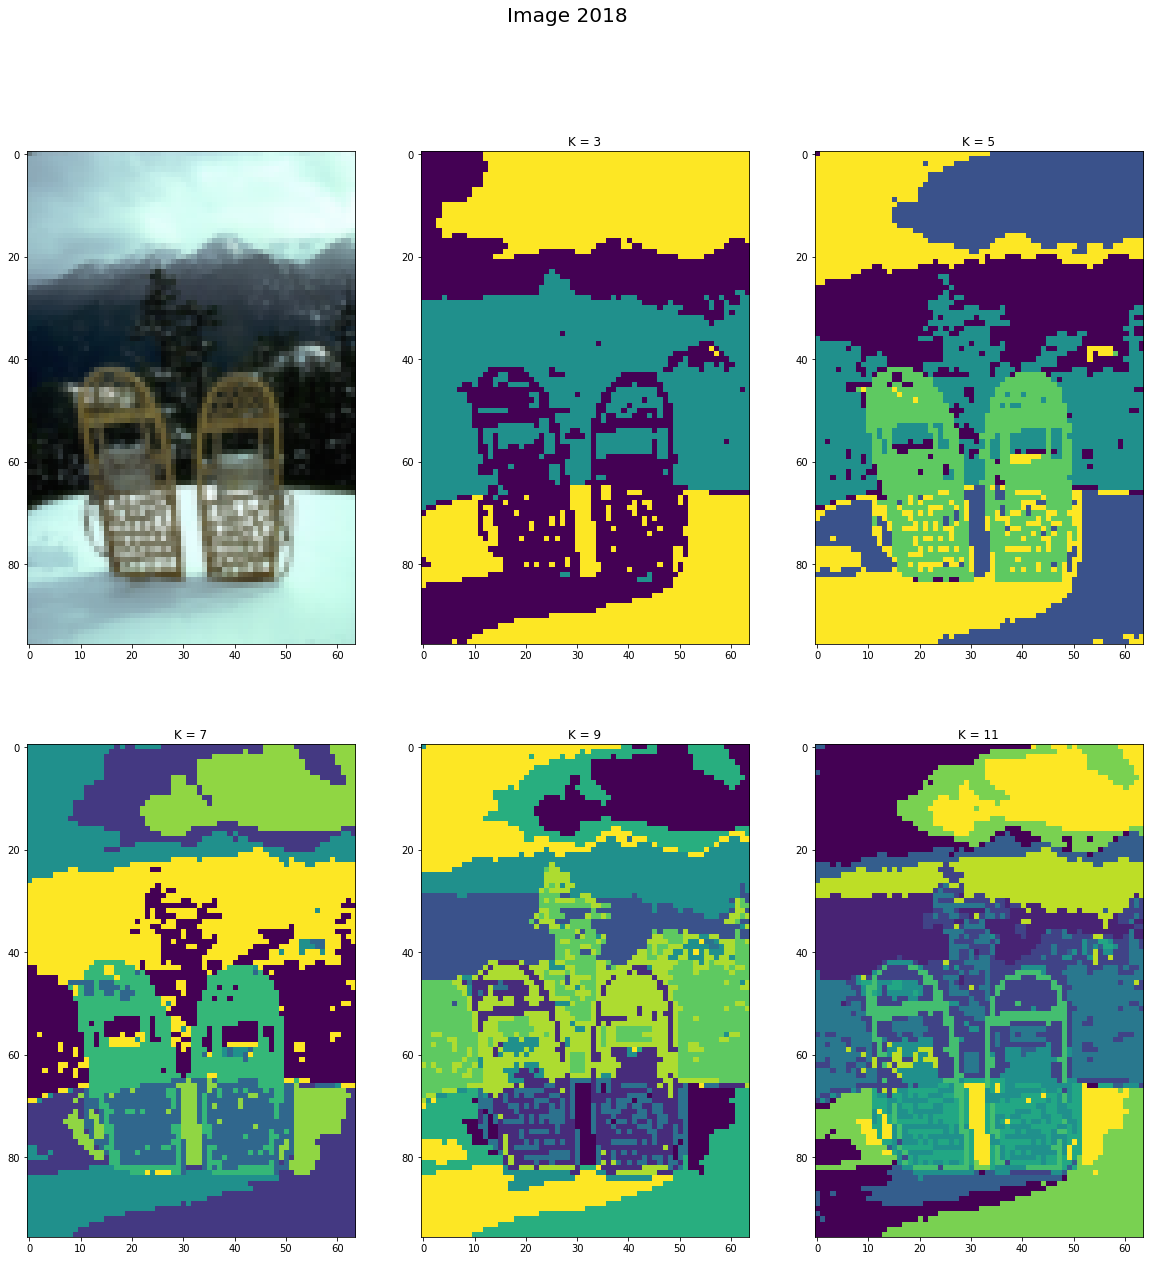

RBF with gamma = 10


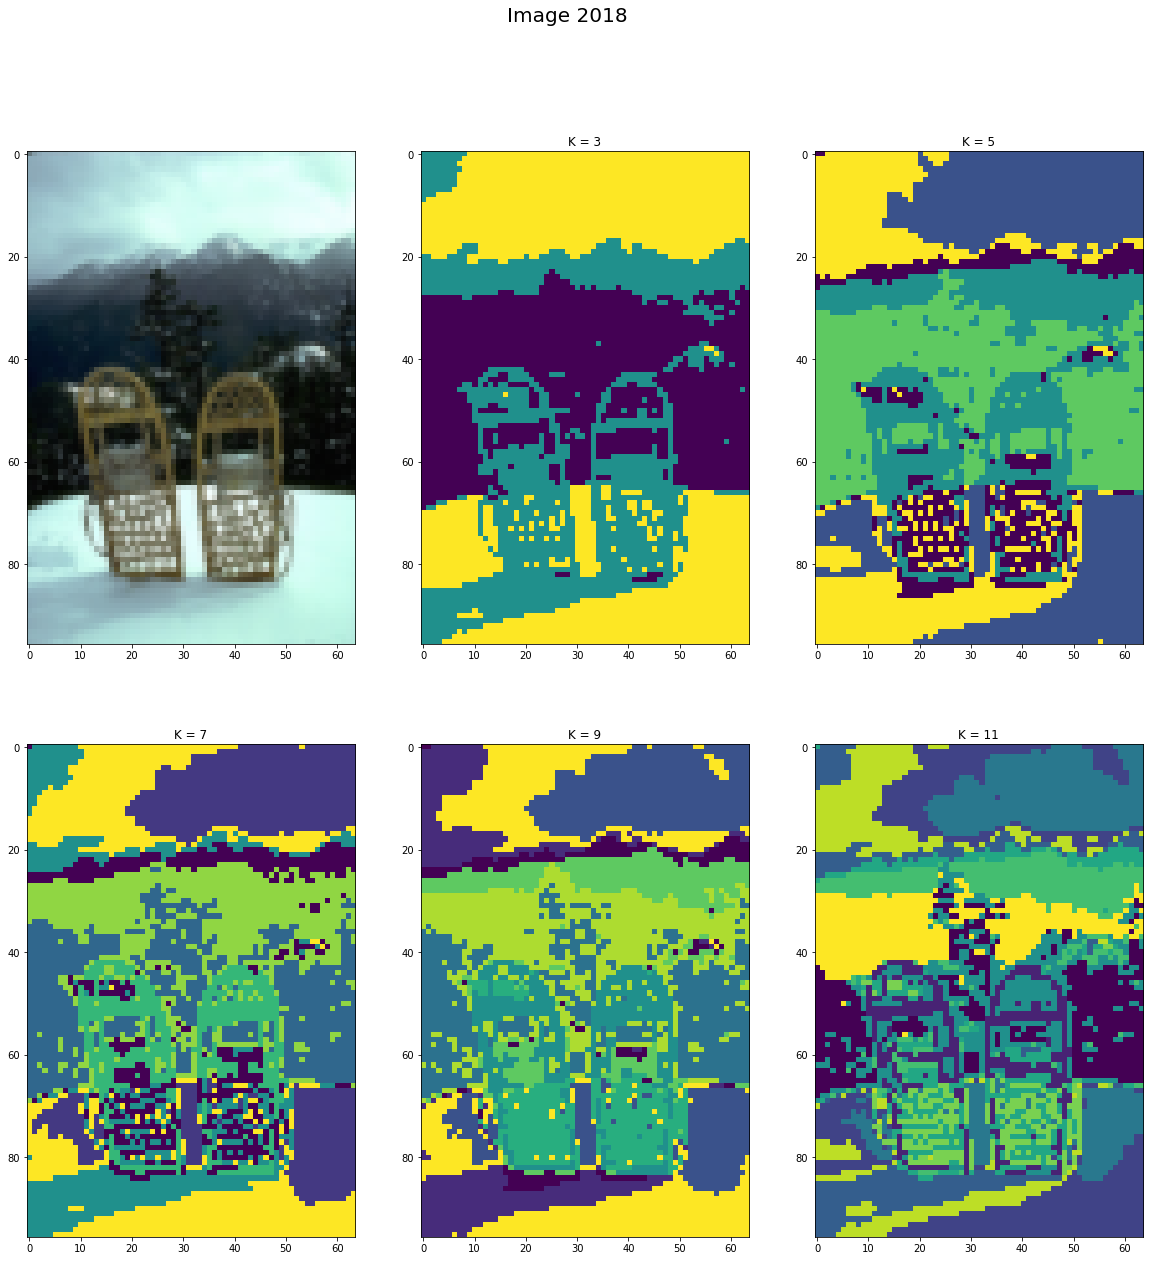

Nearest Neighbours with n = 5


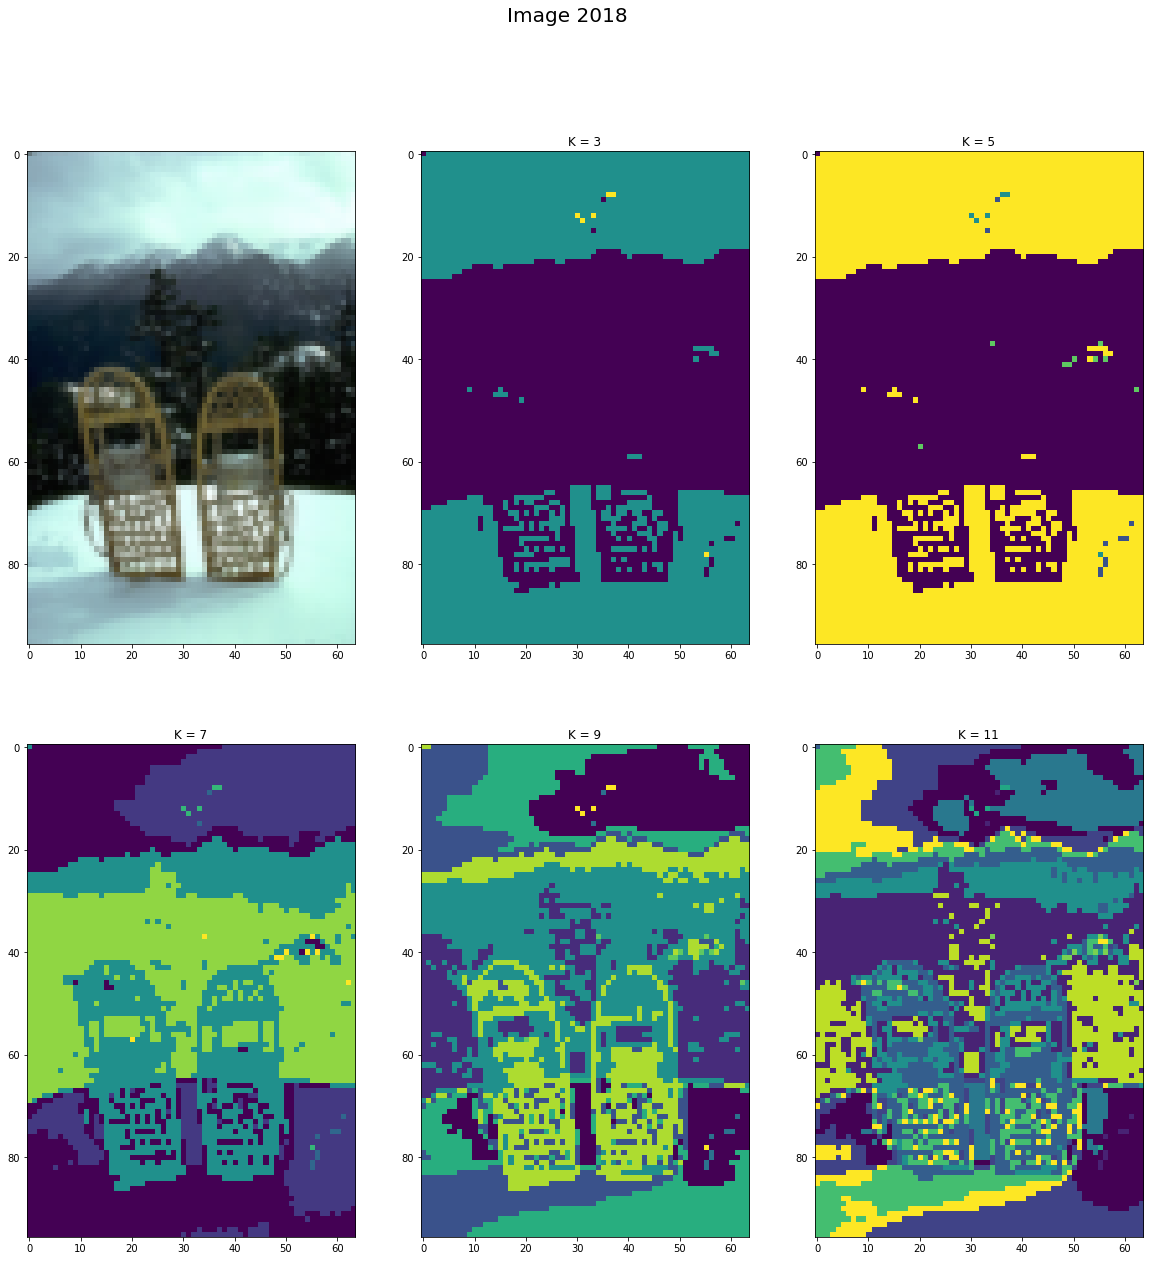

In [84]:
directory = 'results/spectral/rbf_1'
k_param = [3,5,7,9,11];
s_results = [[] for j in range(3)];
for k in k_param:
    sub_dir = join(directory, str(k));
    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir);
    lk = read_cluster_images(sub_dir);
    s_results[0].append(lk);
directory = 'results/spectral/rbf_10'
k_param = [3,5,7,9,11];
for k in k_param:
    sub_dir = join(directory, str(k));
    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir);
    lk = read_cluster_images(sub_dir);
    s_results[1].append(lk);
directory = 'results/spectral/nn_5'
k_param = [3,5,7,9,11];
for k in k_param:
    sub_dir = join(directory, str(k));
    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir);
    lk = read_cluster_images(sub_dir);
    s_results[2].append(lk);
print('RBF with gamma = 1');
show_cluster_img(mod_data, s_results[0], names, 0, k_param);
print('RBF with gamma = 10');
show_cluster_img(mod_data, s_results[1], names, 0, k_param);
print('Nearest Neighbours with n = 5');
show_cluster_img(mod_data, s_results[2], names, 0, k_param);

In [22]:
from img_measures import get_measures as measure;
def calculate_measures_k(gt_data, k_results, names, index, k_param):
    print("Image " + names[index])
    for k in k_param:
        print("k = " + str(k) + ":");
        kimg = k_results[k][index].reshape(-1);
        print(str(len(kimg)));
        for m in range(len(gt_data[index])):
            print("m = " + str(m) + ":");
            gt_img = gt_data[index][m].reshape(-1);
            print(str(len(gt_img)));
            [f, e] = measure(gt_img, kimg);
            print("F-measure : " + f);
            print("Conditional Entropy : " + e);
            